# Example-08: GALI

In [1]:
# In this example, a basic application of the Generalized Alignment Index (GALI) indicator is presented

# Import

import numpy

from tqdm import tqdm

import jax
from jax import jit
from jax import vmap

# Test symplectic mapping and corresponding inverse

from tohubohu.util import forward4D

# GALI factory

from tohubohu import gali

# Plotting

from matplotlib import pyplot as plt
from matplotlib import colormaps

cmap = colormaps.get_cmap('viridis_r')
cmap.set_bad(color='lightgray')

In [2]:
# Set data type

jax.config.update("jax_enable_x64", True)

In [3]:
# Set device

device, *_ = jax.devices('cpu')
jax.config.update('jax_default_device', device)

In [4]:
# Set mapping parameters

nux, nuy = 0.168, 0.201
mux, muy = 2*jax.numpy.pi*nux, 2*jax.numpy.pi*nuy
cx, sx, cy, sy = jax.numpy.cos(mux), jax.numpy.sin(mux), jax.numpy.cos(muy), jax.numpy.sin(muy)
mu = 0.0

k = jax.numpy.asarray([cx, sx, cy, sy, mu])

In [5]:
# Set and compile indicator

@jit
def fn(x):
    return jax.numpy.log10(1.0E-16 + gali(2**12, forward4D)(x, vs, k))

x = jax.numpy.array([0.25, 0.25, 0.0, 0.0])
vs = jax.numpy.array([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]])

out = fn(x)

In [6]:
# Set initial grid in (qx, qy) plane

n = 1001

qx = jax.numpy.linspace(0.0, 0.6, n)
qy = jax.numpy.linspace(0.0, 0.6, n)
qs = jax.numpy.stack(jax.numpy.meshgrid(qx, qy, indexing='ij')).swapaxes(-1, 0).reshape(n*n, -1)
ps = jax.numpy.full_like(qs, 1.0E-12)
xs = jax.numpy.hstack([qs, ps])
xs = jax.numpy.array_split(xs, n)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:19<00:00,  3.85it/s]


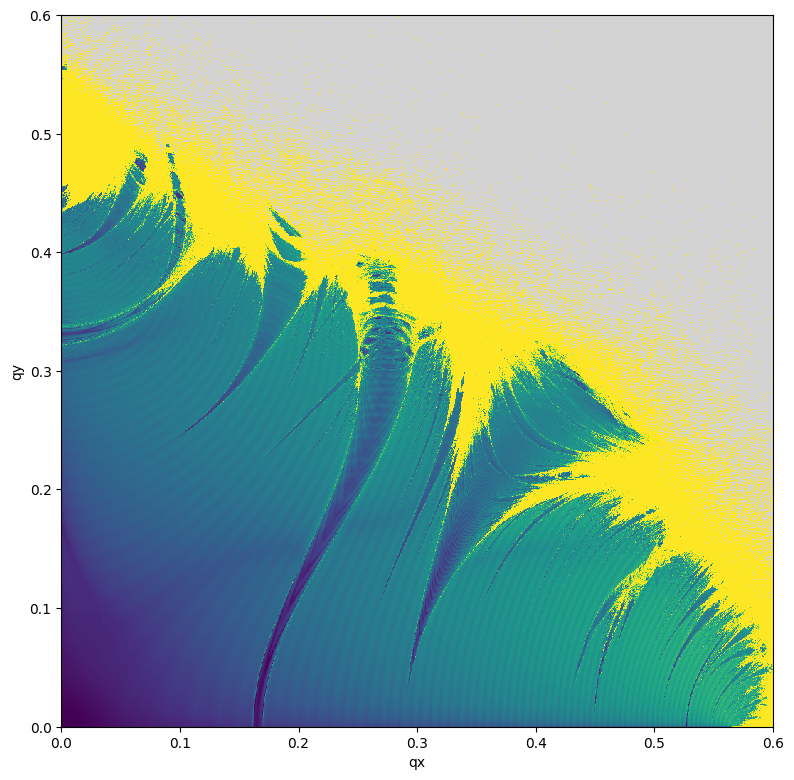

In [7]:
# Evaluate indicator

xb, *xr = xs
fj = jit(vmap(fn))
out = [fj(xb)]

for xb in tqdm(xr):
    out.append(fj(xb))
out = jax.numpy.concatenate(out)

# Winsorize data

data = numpy.array(out)
data[data < -16.0] = -16.0
data[data > 0.0] = 0.0
data = data.reshape(n, n)

# Plot 

plt.figure(figsize=(8, 8))
plt.imshow(data, aspect='equal', vmin=-16.0, vmax=0.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(0., 0.6, 0., 0.6))
plt.xlabel('qx')
plt.ylabel('qy')
plt.tight_layout()
plt.show()